# Feature Evaluation

This program will perform feature extraction, feature analyzation and machine learning for fake news detections:
1. Gather the news data from NewsAPI.org
2. Extract the individual features from news data
3. Extract the relational features from news data
4. Feature analyzation
5. Test with machine learning

Date: Feb 26th, 2020</br>
Programmed by: Sasung Kim, Christophe Liu

# Setting up

In [2]:
# Import required modules
# For NewsAPI
import requests
import numpy as np
import pandas as pd
import csv

# For Individual Feature Extraction 
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from collections import Counter

# For Relational Feature Extraction
from statistics import mean
import math

# For feature analyzation
#enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# increase size of output window
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 50em; }</style>"))

# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# For machine learning
from sklearn import svm
from sklearn.svm import SVC

# Modeling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Cross-validation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Saving
import joblib
from joblib import dump, load

# News Scrap API

<h4>This program scraps a news about specific topic from newsapi.org API.</h4>
To change topic (or select topic), change q = '' part
To get specific news domain, use domains = '<news domain url>&'
Use page=#& to get more results

Data includes: Author, title, description, url, content, publishing date, source ID

In [20]:
def news_api(topic, number, source, date, reliability):
    # List creation
    source_id = []
    author = []
    title = []
    description = []
    url = []
    content = []
    pub_date = []
    rel = []

    #set the reliability list by user input
    if reliability is 1:
        rel = np.ones(number)
    elif reliability is 0:
        rel = np.zeros(number)
    
    # Read 100 news articles about coronavirus (20 articles per each page, 5 pages) and parse each data into corresponding lists
    for i in range(1, int((number/20)+1)):

        # News extraction
        news_url = ('https://newsapi.org/v2/everything?'
                f'domains={source}&'
                f'q={topic}&'
               f'page={i}&'
               f'from={date}&'
               'sortBy=popularity&'
               'apiKey=ddb22f3ef2b54abe8af228db83421424')

        news = requests.get(news_url)
        
        print((news.json()['totalResults']))
    
        for elements in news.json()['articles']:
            source_id.append(elements['source']['id'])
            author.append(elements['author'])
            title.append(elements['title'])
            description.append(elements['description'])
            url.append(elements['url'])
            content.append(elements['content'])
            pub_date.append(elements['publishedAt'])

            # *For CNN Only: check if the content is video and data does not related to the article
            #if (elements['content'] == 'None' or elements['content'] == "Chat with us in Facebook Messenger. Find out what's happening in the world as it unfolds."):
            #    pass
                #print(elements['description'])
            #else:
                #print (elements['content'])
            #    pass
    
    # Test for parsed data
    #print(author)
    news_info = pd.DataFrame()
    news_info['source_id'] = source_id
    news_info['author'] = author
    news_info['title'] = title
    news_info['description'] = description
    news_info['url'] = url
    news_info['content'] = content
    news_info['published_date'] = pub_date
    news_info['label'] = rel
    return news_info
    

    
news = news_api('economy', 100, 'www.cbc.ca', '2020-01-30', 1)
text = news_api('economy', 100, 'youtube.com, wsj.com', '2020-01-30', 0)

ref = news_api('economy', 100, 'cnn.com', '2020-01-30', 1)

print(news['description'].head(5))


258
258
258
258
258
184
184
184
184
184
210
210
210
210
210
0    Premier Scott Moe promises more money for Sask...
1    China's president visits health centre as coro...
2    California-based technology reporter Kari Paul...
3    Countries began isolating hundreds of citizens...
4    A global recession would likely kill more peop...
Name: description, dtype: object


# Individual Feature Extraction

This portion of code is for individual feature extraction from given data.

At the beginning, the program grab the description from the given dataset and extract the features from the news contents.
Then, it output extracted data and features as dataframe.

Features used in this program are:
1. Number of Characters
2. Number of Words
3. Number of Verbs
4. Number of Nouns
5. Number of Sentence
6. Average Number of Words per Sentence
7. Average Number of Characters in Words
8. Number of Question Marks (?)
9. Percentage of Subjective Verbs
10. Percentage of Passive Voice
11. Percentage of Positive Words
12. Percentage of Negative Words
13. Lexical Diversity: Unique Words or Terms
14. Typographical Error Ration: Misspelled Words
15. Causation Terms
16. Percentage of generalizing terms
17. Percentage of numbers and quantifiers
18. 1st person pronouns
19. 2nd and 3rd person pronouns
20. Exclusive terms
21. Number of exclamation marks (!)
22. Lexical
23. Singular pronouns (1st person)
24. Group ref pronouns (1st person)
25. 2nd and 3rd pronouns

How to use: First, place positive-words.txt and negative-words.txt files in word_sentiment folder and put
            .csv dataset in liar_dataset folder in datasets folder and put the name of the .csv file
            in argument space of setup_data function. Next, use feature_extraction function with the result of
            setup_data function to extract the features and save the data in the desired file.



In [21]:
# Create the lists of the words that used for feature extraction

positive_list = list()
negative_list = list()

# Gather the positive and negative word lists from the text file
with open('./word_sentiment/positive-words.txt') as p:
    for line in p:
        val = line.split()
        for ele in val:
            positive_list.append(ele)

with open('./word_sentiment/negative-words.txt') as n:
    for line in n:
        val = line.split()
        for ele in val:
            negative_list.append(ele)

subjective_list = list(['am', 'are', 'is', 'was', 'were', 'be', 'been'])
causation_list = list(['led to', 'because', 'cause', 'caused', 'reason', 'explanation', 'so'])

exclusive_list = list(['except', 'else', 'besides', 'without', 'exclude', 'other than'])
generalizing_list = list(['all', 'none', 'most', 'many', 'always', 'everyone','never',
                          'some','usually','few','seldom','generally','general','overall'])
pronoun_1st_list = list(['I','we'])
pronoun_2nd3rd_list = list(['you','your','yours','he','she','it','him','her','his','her','its','hers','They','them','theirs','their'])

SPronoun_list = list(['I', 'mine','my','me'])
GPronoun_list = list(['we','ours','our','us'])

In [22]:
# From the dataset, isolate the required data (statement and label in this program) and return as pandas Series
# If the user needs the required data as a file, uncomment def with new_file as argument and comment the other one

#def setup_data(file_name, new_file):
def setup_data(news_info):
    
    # Check for data reading
    #print(news_info.head(5))
    
    # Check for the raw data from original dataset
    # print (list(data.columns.values))
    # print(data.tail(1))

    data = pd.DataFrame()
    news_contents = []
    label_list = []
    
    for elements in range(len(news_info)):
        description = news_info.loc[elements, 'description']
        label = news_info.loc[elements, 'label']
        
        # uncomment and indent the news_contents.append(description) line if both contents and descriptions are used instead of  description only
        
        #content = data.loc[elements, 'content']
        #if not pd.isna(content) and content is "Chat with us in Facebook Messenger. Find out what's happening in the world as it unfolds.":
        #    news_contents.append(content)
        #else:
        news_contents.append(description)
    
        label_list.append(label)

    
    data['description'] = news_contents
    data['label'] = label_list
    
    # drop the null values (if both content and description are null)
    data = data.dropna(how = 'any')
    for i in range(len(data)):
        try:
            if (len(data['description'][i]) == 0):
                data = data.drop(i)
            else:
                pass
        except:
            pass
    return data

# Data Extraction
# From the dataset file, gather the news contents and labels only

text_data = setup_data(text)
news_data = setup_data(news)
ref_data = setup_data(ref)

print(text_data.head(5))
print(news_data.head(5))

                                         description  label
0  WATCH LIVE: Federal Reserve Chairman Powell te...    0.0
1  China Vows More Fiscal Support as Virus Roils ...    0.0
2  Feb.05 -- President Donald Trump talks about t...    0.0
3  Beijing imposes strict quarantine rules | WION...    0.0
4  Coronavirus outbreak: Virus now deadlier than ...    0.0
                                         description  label
0  Premier Scott Moe promises more money for Sask...    1.0
1  China's president visits health centre as coro...    1.0
2  California-based technology reporter Kari Paul...    1.0
3  Countries began isolating hundreds of citizens...    1.0
4  A global recession would likely kill more peop...    1.0


In [23]:
# Input: String ('str')
# Description: Tockenize and tag input with nltk universal tag
# Return: tags of each tockens - String ('tagged')
# Tockenize and tag input String with nltk universal tag and return the tags for each words in the String

def tagging_univ(str):
    text = nltk.word_tokenize(str)
    tagged = nltk.pos_tag(text, tagset='universal')
    return tagged

# Input: String('str')
# Description: Tockenize and tag input with nltk non-universal tag
# Return: tags of each tockens - String ('tagged')

def tagging_nuniv(str):
    text = nltk.word_tokenize(str)
    tagged = nltk.pos_tag(text)
    return tagged

# Input: String('str')
# Description: Count the number of characters in input
# Return: Character count - int ('count')

def count_char(str):
    no_space = str.replace(" ", "")
    count = len(no_space)
    return count

# Input: String('str')
# Description: Count the number of words in input
# Return: Word count - int ('count')

def count_word(str):
    count = len(str.split())
    return count

# Input: String ('str')
# Description: Count the number of sentences by counting number of period(.)
# Return: Sentence count - int ('sentence')

def count_sent(str):
    sentence = len(str.split('.'))
    return sentence

# Input: String ('states')
# Description: Count the number of characters in each word in input and average the number of characters per word
# Return: Average number of characters: float ('avg')

def count_char_per_word(states):
    word = []
    word.append(states.split())
    char_per_word = list()
    for elements in word:
        for char in elements:
            c_in_w_count = len(char)
            char_per_word.append(c_in_w_count)
    # char_per_word_list.append()
    avg = sum(char_per_word) / len(char_per_word)
    char_per_word.clear()
    return avg

# Input: String ('tagged'), String ('tag'), count ('int')
# Description: Count the number of specified tags ('tag') from the input
# Return: Count of specified tag - int ('int')

def check_tag(check, tag, count):
    if check == tag:
        count += 1
    return count

# Input: String ('tagged'), list ('list'), int ('int')
# Description: Count the number of common words between input String and input list
# Return: Count of common words - int ('int')
# Count and return the number of words that is included in the given list in the statement

def check_common(state, list, count):
    #for ele in list:
    #    count = tagged.count(ele)
    #return count
    for elements in list:
        for words in state.split():
            if words == elements:
                count += 1
    return count

# Input: String ('word'), String ('tag'), list ('subjective_list'), int ('sent_count')
# Description: Count the number of passive voice and avarge it from number of sentence (sent_count)
# Return: Average of passive voiced sentences - float ('result')

def count_passive(word, tag, subjective_list, sent_count):
    percent_sub = 0
    counter = 0
    for ele in subjective_list:
        if (word.count(ele) > 0 and tag == "VBN"):
            counter += 1
    result = counter / sent_count * 100
    return result

# Input: String ('states')
# Description: Count the words that introduced only once in input
# Return: Count of unique words - int ('unique_count')

def count_unique(states):
    words = states.split(' ')
    c = Counter(words)
    unique = [w for w in words if c[w] == 1]
    unique_counter = len(unique)
    return unique_counter

# Calvin
def avg_char(states):
    word.append(states.split())
    char_per_word = list()
    for elements in word:
        for char in elements:
            c_in_w_count = len(char)
            char_per_word.append(c_in_w_count)
    word.clear()
    avg = sum(char_per_word)/len(char_per_word)
    char_per_word.clear()
    return avg


# Input: panda Series ('data'), String ('save_file_name')
# Description: First, this function creates lists for each features and extract the features using statements in dataset and
#              above functions. Next, it creates a large pandas Series that consist of news contents, labels and extracted
#              features. Finally, it save the final pandas Series in a file to make easier to examine the result (do not need
#              to rerun the program or change the code to check raw data)
# Return: Pandas Series consist of news contents, labels and extracted features count - pandas Series ('new')

def feature_extract(data):
    # define the news contents and labels from the dataset
    state = data['description']
    label = data['label']
    
    # Create a dataframe that will store every feature values
    ind_feature = pd.DataFrame()

    # create lists for storing the counters
    char_count_list = list()
    word_count_list = list()
    verb_count_list = list()
    noun_count_list = list()
    sent_count_list = list()
    words_per_sent_list = list()
    char_per_word_list = list()
    quest_count_list = list()
    sub_count_list = list()
    pass_count_list = list()
    pos_count_list = list()
    neg_count_list = list()
    unique_count_list = list()
    typo_count_list = list()
    cause_count_list = list()
    
    # Calvin
    gene_count_list = list()
    num_count_list = list()
    pron_1st_count_list = list()
    pron_2nd3rd_count_list = list()
    exclu_count_list = list()
    
    # Andrew
    exclam_list = list()
    lex_list = list()
    singlulars_list = list()
    group_list = list()
    other_list = list()


    word = list()

    #print(type(state))
    # loop for checking each new contents in dataset
    for states in state:

        #print(states)
        # reset the counters for each news contents
        w_in_s_count = 0
        c_in_w_count = 0
        verb_count = 0
        noun_count = 0
        sub_count = 0
        pos_count = 0
        neg_count = 0
        percent_pos = 0
        percent_neg = 0
        unique_count = 0
        sent_counts = 0
        typo_count = 0
        cause_count = 0
        gene_count = 0
        pron_1st_count = 0
        pron_count = 0
        exclu_count = 0
        SelfP = 0
        count_prongroup = 0
        group = 0
        other = 0
        num= 0
        
        # Tockenization and tagging with nltk universal and non-universal tag systems (tagged = universal, tagged_nu = non-universal)
        tagged = tagging_univ(states)
        tagged_nu = tagging_nuniv(states)

        # Check the tags of each news contents
        # print(tagged)
        # print(tagged_nu)

        # Extract the features and append the results in the list. Commented lines with print() functions are for testing

        # 1. Number of Characters
        char_count = count_char(states)
        char_count_list.append(char_count)

        # 2. Nubmer of Words
        word_count = count_word(states)
        word_count_list.append(word_count)

        # 3. Number of Verbs
        for tag in tagged:
            verb_count = check_tag(tag[1], 'VERB', verb_count)
        verb_count_list.append(verb_count)

        # 4. Number of Nouns
        for tag in tagged:
            noun_count = check_tag(tag[1], 'NOUN', noun_count)
        noun_count_list.append(noun_count)
        # print(noun_count)

        # 5. Number of Sentence
        sent_count = count_sent(states)
        sent_count_list.append(sent_count)
        # print(sent_count)

        # 6. Average number of words per sentence
        sent = [len(l.split()) for l in re.split(r'[?!.]', states) if l.strip()]
        w_in_s_count = (sum(sent) / len(sent))
        words_per_sent_list.append(w_in_s_count)
        # print(w_in_s_count)

        # 7. Average number of characters per word
        c_in_w_count = count_char_per_word(states)
        char_per_word_list.append(c_in_w_count)
        # print(c_in_w_count)

        # 8. Number of question marks
        quest_count = states.count("?")
        quest_count_list.append(quest_count)

        # 9. Percentage of subjective verbs - am/are/is/etc
        sub_count = check_common(states, subjective_list, sub_count)
        if (verb_count > 0):
            percent_sub = sub_count / verb_count * 100
        sub_count_list.append(percent_sub)

        # 10. Percentage of passive voice - am/are/is && past participate
        for tag in tagged_nu:
            passive_percent = count_passive(tag[0], tag[1], subjective_list, sent_count)
        pass_count_list.append(passive_percent)

        # 11. Percentage of positive words
        for tag in tagged:
            pos_count = check_common(tag[0], positive_list, pos_count)
            percent_pos = pos_count / word_count * 100
        pos_count_list.append(percent_pos)

        # 12. Percentage of negative words
        for tag in tagged:
            neg_count = check_common(tag[0], negative_list, neg_count)
            percent_neg = neg_count / word_count * 100
        neg_count_list.append(percent_neg)

        # 13. Lexical diversity: unique words or terms
        unique_count = count_unique(states)
        unique_count_list.append(unique_count)

        # 14. Typographical error ratio: misspelled words
        for tag in tagged:
            typo_count = check_tag(tag[1], 'X', typo_count)
        typo_count_list.append(typo_count)

        # 15. Causation terms
        cause_count = check_common(states, causation_list, cause_count)
        cause_count_list.append(cause_count)

        # 16. Percentage of generalizing terms
        gene_count = check_common(states, generalizing_list, gene_count)
        gene_count_list.append(gene_count)
        
        # 17. Percentage of numbers and quantifiers
        for tag in tagged:
            num = check_tag(tag[1], 'NUM', num)
        num_count_list.append(num)

        # 18. 1st person pronouns
        pron_1st_count = check_common(states, pronoun_1st_list, pron_1st_count)
        pron_1st_count_list.append(pron_1st_count)
   
        # 19. 2nd and 3rd person pronouns
        pron_count = check_common(states, pronoun_2nd3rd_list, pron_count)
        pron_2nd3rd_count_list.append(pron_count)

        # 20. Exclusive terms
        exclu_count = check_common(states, exclusive_list, exclu_count)
        exclu_count_list.append(exclu_count)
        
        # 21. # of exclamation marks
        exclam_count = states.count("!")
        exclam_list.append(exclam_count)
        
        # 22. lexical 
        unique_count = count_unique(states)
        lex_list.append(unique_count)
        
        # 23. singlular pronouns (1st person)
        SelfP = check_common(states, SPronoun_list, SelfP)
        singlulars_list.append(SelfP)
        
        # 24. Group ref pronouns (1st person)
        group = check_common(states, GPronoun_list, group)
        group_list.append(group)
        
        # 25. 2nd 3rd pronouns
        other = check_common(states, pronoun_2nd3rd_list, other)
        other_list.append(other)
        

    # Put the data into a dataframe
        
    ind_feature['Statement'] = state
    ind_feature['Label'] = label
    ind_feature['# of Characters'] = char_count_list
    ind_feature['# of Words'] = word_count_list
    ind_feature['# of Verbs'] = verb_count_list
    ind_feature['# of Noun'] = noun_count_list
    ind_feature['# of Sentence'] = sent_count_list
    ind_feature['Average # of Words per Sentence'] = words_per_sent_list
    ind_feature['Average # of Characters per Words'] = char_per_word_list
    ind_feature['# of Question Marks'] = quest_count_list
    ind_feature['% of Subjective Verbs'] = sub_count_list
    ind_feature['% of Passive Voice'] = pass_count_list
    ind_feature['% of Positive Words'] = pos_count_list
    ind_feature['% of Negative Words'] = neg_count_list
    ind_feature['# of Unique Wrods/Terms'] = unique_count_list
    ind_feature['# of Misspelled Words'] = typo_count_list
    ind_feature['# of Causation Terms'] = cause_count_list
    ind_feature['% of generalizing terms'] = gene_count_list
    ind_feature['% of # and quantifiers'] = num_count_list
    ind_feature['1st person pronouns'] = pron_1st_count_list
    ind_feature['2nd and 3rd person pronouns'] = pron_2nd3rd_count_list
    ind_feature['Exclusive term'] = exclu_count_list
    ind_feature['# of exclamation marks'] = exclam_list
    ind_feature['Lexical'] = lex_list
    ind_feature['Singular pronouns(1st person)'] = singlulars_list
    ind_feature['Group ref pronouns(1st person)'] = group_list
    ind_feature['2nd 3rd pronouns'] = other_list

    return ind_feature


########################################################################################################################

# Feature Extraction

text_data_FE = feature_extract(text_data)
news_data_FE = feature_extract(news_data)
ref_data_FE = feature_extract(ref_data)

# Checking data

print(text_data_FE.head(5))
print(news_data_FE.head(5))


                                           Statement  Label  # of Characters  \
0  WATCH LIVE: Federal Reserve Chairman Powell te...    0.0              222   
1  China Vows More Fiscal Support as Virus Roils ...    0.0              221   
2  Feb.05 -- President Donald Trump talks about t...    0.0              127   
3  Beijing imposes strict quarantine rules | WION...    0.0              220   
4  Coronavirus outbreak: Virus now deadlier than ...    0.0              224   

   # of Words  # of Verbs  # of Noun  # of Sentence  \
0          39           3         30              1   
1          40           6         21              1   
2          25           0         15              3   
3          41           7         22              3   
4          37           9         16              2   

   Average # of Words per Sentence  Average # of Characters per Words  \
0                             39.0                           5.692308   
1                             40.0        

# Relational Features

This portion of code extract the multi-sourced features from two dataframes (one is unreliable dataset that text that is evaluated, one for reliable dataset as reference news of evaluation).

Restrictions: Two provided datasets must have the same number of data and have same feature and name. For better use, it is recommended to use the news/texts that have same topics.

How to use: Place the datasets that consists of statements and feature values in a folder and put the name or path of the datasets in news1 and news2 arguments of multi_source_FE() definition.
            news1 should be the dataset of referencing articles, and news2 should be the dataset of testing texts

In [24]:
# Subtract each feature values for each data in the same row (one-to-one). List contains
# the extracted feature values related to texts. Ex. feature_list[0] = all feature values of first statement
# In case of there is null in the reference data, use two next reference data

def one_to_one_dif(text, ref):
    feature_list = []
    feature = 0
    for i in range (len(text)):
        try:
            feature = (float(text[i]) - float(ref[i]))
        except:
            try:
                feature = (float(text[i]) - float(ref[i+2]))
            except:
                pass

        feature_list.append(round(feature, 2))
    return feature_list
    
# Subtract each feature values for each data in the same row and repeat it with different references.(one-to-many)
# Then, average the difference. List contains the extracted feature values related to texts.
# Ex. final_list[0] = all feature values of first statement
# In case of there is null in the reference data, use two next reference data

def one_to_many_dif(text, ref):
    avg_list = []
    final_list = []
    for i in range(len(text)):
        for j in range(len(ref)):
            try:
                feature_val = float(text[i]) - float(ref[j])
            except:
                try:
                    feature_val = float(text[i]) - float(ref[i+2])
                except:
                    pass
            avg_list.append(feature_val)
        avg = round(mean(avg_list), 2)
        final_list.append(avg)
    return final_list
    
    
# Input: news1 (String), news2 (String), outFile (String), startFColumn (integer)
# Description: Read the data from news1 (reliable) and news2 (unreliable), and put the data in two lists. Then, subtract the news1 values in each column from news2 values.
#              The subtraction starts from startFColumn until the end of the .csv file. Next, the results will be saved in the file with given name or path from user (outFile)
#
# Return: New DataFrame ('MS_features')

def multi_source_FE(text, ref):

    # Saving original headers in header
    header = list(text)
    
    # Only feature values
    cols = [col for col in news_data_FE.columns if col not in ['Statement', 'Label']]
    
    # Assign data of the testing text and referencing text in data1 and data2
    if(text.equals(ref)):
        ref = text.shift(periods = 1)
        ref.iloc[0] = text.iloc[len(text)-1]
    
    state_text = text['Statement']
    state_ref = ref['Statement']
    label_text = text['Label']
    data_text = text[cols]
    data_ref = ref[cols]

    feature_num = len(data_text.keys())


    # Create local lists, dataframe that are used later in this definition.
    df = pd.DataFrame()
    sub = pd.DataFrame()
    avg_sub = pd.DataFrame()
    text = []
    ref = []
    total_list = []
    new_total_list = []
    
    # Loop through the data for subtraction
    for i in data_text.keys():
        sub[i + "- sub"] = one_to_one_dif(data_text[i], data_ref[i])
        avg_sub[i + "- avg sub"] = one_to_many_dif(data_text[i], data_ref[i])
    
    # Creating dataframe with multi-sourced features
    df['Text'] = state_text
    df['Reference'] = state_ref
    df['Label'] = label_text
    
    # Concatenate the text, reference and features, then drop null values
    df1 = pd.concat([df, data_text, sub, avg_sub], axis = 1)
    df1 = df1.dropna(how = 'any')
    
    return df1

# Initiate the code and check for the dataframe
text_feature = multi_source_FE(text_data_FE, ref_data_FE)
news_feature = multi_source_FE(news_data_FE, ref_data_FE)

print(text_feature.head(5))
print(news_feature.head(5))

                                                Text  \
0  WATCH LIVE: Federal Reserve Chairman Powell te...   
1  China Vows More Fiscal Support as Virus Roils ...   
2  Feb.05 -- President Donald Trump talks about t...   
3  Beijing imposes strict quarantine rules | WION...   
4  Coronavirus outbreak: Virus now deadlier than ...   

                                           Reference  Label  # of Characters  \
0  Federal Reserve chairman Jerome Powell on Tues...    0.0              222   
1  CNN's Alisyn Camerota speaks with South Caroli...    0.0              221   
2  The State of the Union address Tuesday night g...    0.0              127   
3  The US economy expanded at an annualized rate ...    0.0              220   
4  Fareed gives his take on the folly of Trump's ...    0.0              224   

   # of Words  # of Verbs  # of Noun  # of Sentence  \
0          39           3         30              1   
1          40           6         21              1   
2          25    

In [25]:
# Concatenate the unreliable and reliable datasets to create mixed dataset
data = pd.concat([text_feature, news_feature])
data.to_csv("ActualNewsFeatureData.csv")
print(data.head(5))

                                                Text  \
0  WATCH LIVE: Federal Reserve Chairman Powell te...   
1  China Vows More Fiscal Support as Virus Roils ...   
2  Feb.05 -- President Donald Trump talks about t...   
3  Beijing imposes strict quarantine rules | WION...   
4  Coronavirus outbreak: Virus now deadlier than ...   

                                           Reference  Label  # of Characters  \
0  Federal Reserve chairman Jerome Powell on Tues...    0.0              222   
1  CNN's Alisyn Camerota speaks with South Caroli...    0.0              221   
2  The State of the Union address Tuesday night g...    0.0              127   
3  The US economy expanded at an annualized rate ...    0.0              220   
4  Fareed gives his take on the folly of Trump's ...    0.0              224   

   # of Words  # of Verbs  # of Noun  # of Sentence  \
0          39           3         30              1   
1          40           6         21              1   
2          25    

# Feature Analyzation

This portion of code is for evaluating existing features on redundancy/irrelevancy by preliminary graph analysis of feature value distributions, and if necessary, transforming the distributions. Majority of methods used in this notebook is based on:

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
other resources:

intro to feature selection: https://quantdare.com/what-is-the-difference-between-feature-extraction-and-feature-selection/
feature selection method: https://www.datacamp.com/community/tutorials/feature-selection-python
feature selection tools: https://scikit-learn.org/stable/modules/feature_selection.html
graph usage in representing data: https://365datascience.com/chart-types-and-how-to-select-the-right-one/
Issues:

"The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations." reliability have 2 discrete categories (reliable and unreliable), how to do bivariate analysis? can't use scatter plot. heat map doesn't seem to work?

In [26]:
data.columns

Index(['Text', 'Reference', 'Label', '# of Characters', '# of Words',
       '# of Verbs', '# of Noun', '# of Sentence',
       'Average # of Words per Sentence', 'Average # of Characters per Words',
       '# of Question Marks', '% of Subjective Verbs', '% of Passive Voice',
       '% of Positive Words', '% of Negative Words', '# of Unique Wrods/Terms',
       '# of Misspelled Words', '# of Causation Terms',
       '% of generalizing terms', '% of # and quantifiers',
       '1st person pronouns', '2nd and 3rd person pronouns', 'Exclusive term',
       '# of exclamation marks', 'Lexical', 'Singular pronouns(1st person)',
       'Group ref pronouns(1st person)', '2nd 3rd pronouns',
       '# of Characters- sub', '# of Words- sub', '# of Verbs- sub',
       '# of Noun- sub', '# of Sentence- sub',
       'Average # of Words per Sentence- sub',
       'Average # of Characters per Words- sub', '# of Question Marks- sub',
       '% of Subjective Verbs- sub', '% of Passive Voice- sub',
      

In [27]:
data.head(n=3)

,Text,Reference,Label,# of Characters,# of Words,# of Verbs,# of Noun,# of Sentence,Average # of Words per Sentence,Average # of Characters per Words,...,% of generalizing terms- avg sub,% of # and quantifiers- avg sub,1st person pronouns- avg sub,2nd and 3rd person pronouns- avg sub,Exclusive term- avg sub,# of exclamation marks- avg sub,Lexical- avg sub,Singular pronouns(1st person)- avg sub,Group ref pronouns(1st person)- avg sub,2nd 3rd pronouns- avg sub
0,WATCH LIVE: Federal Reserve Chairman Powell te...,Federal Reserve chairman Jerome Powell on Tues...,0.0,222,39,3,30,1,39.0,5.692308,...,-0.08,0.60,-0.06,-0.69,0.0,0.0,4.40,0.0,-0.1,-0.69
1,China Vows More Fiscal Support as Virus Roils ...,CNN's Alisyn Camerota speaks with South Caroli...,0.0,221,40,6,21,1,40.0,5.525000,...,-0.08,0.09,-0.06,-0.69,0.0,0.0,4.90,0.0,-0.1,-0.69
2,Feb.05 -- President Donald Trump talks about t...,The State of the Union address Tuesday night g...,0.0,127,25,0,15,3,13.0,5.080000,...,-0.08,-0.08,-0.06,-0.36,0.0,0.0,2.07,0.0,-0.1,-0.36


In [28]:
data.describe()

,Label,# of Characters,# of Words,# of Verbs,# of Noun,# of Sentence,Average # of Words per Sentence,Average # of Characters per Words,# of Question Marks,% of Subjective Verbs,...,% of generalizing terms- avg sub,% of # and quantifiers- avg sub,1st person pronouns- avg sub,2nd and 3rd person pronouns- avg sub,Exclusive term- avg sub,# of exclamation marks- avg sub,Lexical- avg sub,Singular pronouns(1st person)- avg sub,Group ref pronouns(1st person)- avg sub,2nd 3rd pronouns- avg sub
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,198.000000,198.000000,198.000000,198.000000,198.0,198.000000,198.000000,198.000000,198.000000,198.000000
mean,0.500000,168.954545,32.191919,4.459596,15.212121,2.681818,22.903199,5.322103,0.060606,12.009434,...,-0.033384,0.305808,-0.056667,-0.201616,0.0,0.044192,2.123838,0.000505,-0.085556,-0.201616
std,0.501267,56.715095,11.290512,2.685907,7.648062,2.256355,12.898185,0.530745,0.239211,14.846038,...,0.035980,0.179856,0.006046,0.263963,0.0,0.062096,1.345276,0.002195,0.018205,0.263963
min,0.000000,43.000000,9.000000,0.000000,2.000000,1.000000,5.000000,4.117647,0.000000,0.000000,...,-0.080000,-0.400000,-0.060000,-0.690000,0.0,0.000000,-2.000000,0.000000,-0.100000,-0.690000
25%,0.000000,134.500000,25.000000,3.000000,9.000000,1.250000,11.000000,4.963294,0.000000,0.000000,...,-0.060000,0.150000,-0.060000,-0.440000,0.0,0.000000,1.340000,0.000000,-0.100000,-0.440000
50%,0.500000,186.500000,36.000000,5.000000,14.000000,2.000000,20.000000,5.365854,0.000000,0.000000,...,-0.040000,0.285000,-0.060000,-0.360000,0.0,0.000000,1.985000,0.000000,-0.100000,-0.360000
75%,1.000000,218.000000,41.000000,6.000000,21.000000,3.000000,35.750000,5.718750,0.000000,25.000000,...,-0.000000,0.437500,-0.050000,0.047500,0.0,0.070000,3.265000,0.000000,-0.070000,0.047500
max,1.000000,227.000000,51.000000,12.000000,36.000000,13.000000,51.000000,6.676471,1.000000,100.000000,...,0.030000,0.780000,-0.040000,0.640000,0.0,0.270000,5.510000,0.010000,-0.040000,0.640000


# Feature data pre-processing

<h2>Data cleaning <!h2>

In [29]:
#analysis of missing data, counting nulls
total_sin = data.isnull().sum().sort_values(ascending=False)
percent_sin = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_sin, percent_sin], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
data.dtypes

,Total,Percent
2nd 3rd pronouns- avg sub,0,0.0
# of Characters- sub,0,0.0
2nd and 3rd person pronouns,0,0.0
Exclusive term,0,0.0
# of exclamation marks,0,0.0
Lexical,0,0.0
Singular pronouns(1st person),0,0.0
Group ref pronouns(1st person),0,0.0
2nd 3rd pronouns,0,0.0
# of Words- sub,0,0.0


Text                                        object
Reference                                   object
Label                                      float64
# of Characters                              int64
# of Words                                   int64
                                            ...   
# of exclamation marks- avg sub            float64
Lexical- avg sub                           float64
Singular pronouns(1st person)- avg sub     float64
Group ref pronouns(1st person)- avg sub    float64
2nd 3rd pronouns- avg sub                  float64
Length: 78, dtype: object

In [30]:
#dropping feature from feature set with missing data past a threshold
news_all = data.drop((missing_data[missing_data['Percent'] > 0.5]).index,1)
#removes all rows containing NaN
data.dropna(inplace=True)
data.isnull().sum().max() #check if any nulls left in set

0

# Graph analysis of feature values

<h2> Univariate analysis </h2>

In [31]:
#standardizing feature
def feature_standard(feature):
    print("standardization result analysis of \033[1m"+var+"\033[0;0m :") # bold text    
    feature_scaled = StandardScaler().fit_transform(data[var][:,np.newaxis]);
    low_range = feature_scaled[feature_scaled[:,0].argsort()][:10]
    high_range = feature_scaled[feature_scaled[:,0].argsort()][-10:]
    print('outer range (low) of the distribution:')
    print(low_range)
    print('\nouter range (high) of the distribution:')
    print(high_range)
    print()

In [32]:
# graphing distributions of feature values
def feature_distrib(feature):
    fig, ax =plt.subplots(1,2)
    #histogram
    sns.distplot(data[var], ax=ax[0]).set_title("For "+feature+" : "
                                                    +"Skewness: %f" % data[var].skew()
                                                    +" Kurtosis: %f" % data[var].kurt())
    #box plot feature x/reliability
    sns.boxplot(x='Label', y=var, data=data, ax=ax[1])
    
    fig.show()
    #probability plot
    fig = plt.figure()
    res = stats.probplot(data[var], plot=plt)

In [33]:
#list of features to analyze
feature_list = [e for e in (list(news_all)) if e not in ('Unnamed: 0','Text', "Reference",'Label')]

In [34]:
for var in feature_list:
    feature_standard(var)

standardization result analysis of # of Characters :
outer range (low) of the distribution:
[[-2.22645881]
 [-2.13807538]
 [-2.04969196]
 [-2.04969196]
 [-2.04969196]
 [-2.04969196]
 [-2.04969196]
 [-2.04969196]
 [-2.04969196]
 [-2.04969196]]

outer range (high) of the distribution:
[[0.95534447]
 [0.97302115]
 [0.97302115]
 [0.97302115]
 [0.99069784]
 [0.99069784]
 [0.99069784]
 [0.99069784]
 [1.00837452]
 [1.02605121]]

standardization result analysis of # of Words :
outer range (low) of the distribution:
[[-2.05931375]
 [-2.05931375]
 [-2.05931375]
 [-2.05931375]
 [-2.05931375]
 [-2.05931375]
 [-2.05931375]
 [-2.05931375]
 [-2.05931375]
 [-2.05931375]]

outer range (high) of the distribution:
[[1.31487542]
 [1.31487542]
 [1.31487542]
 [1.40366987]
 [1.40366987]
 [1.40366987]
 [1.40366987]
 [1.40366987]
 [1.58125877]
 [1.67005322]]

standardization result analysis of # of Verbs :
outer range (low) of the distribution:
[[-1.66457765]
 [-1.66457765]
 [-1.66457765]
 [-1.66457765]
 [-1.6

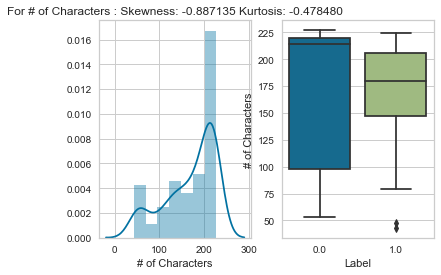

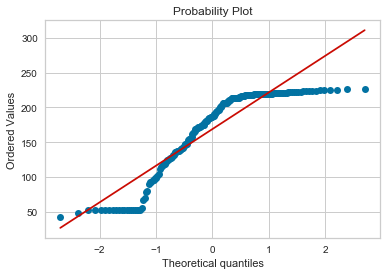

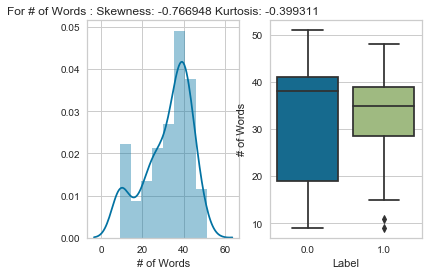

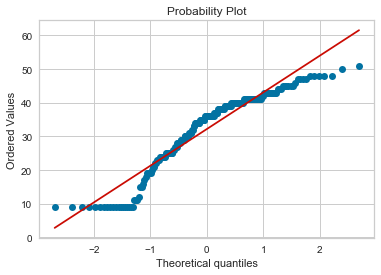

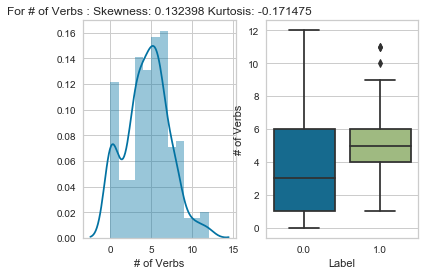

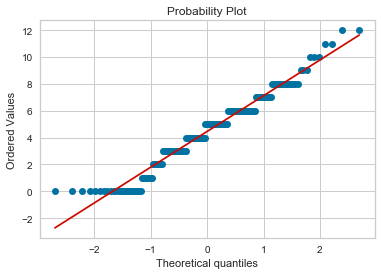

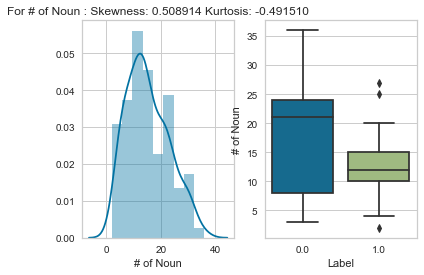

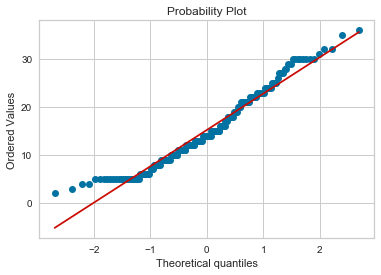

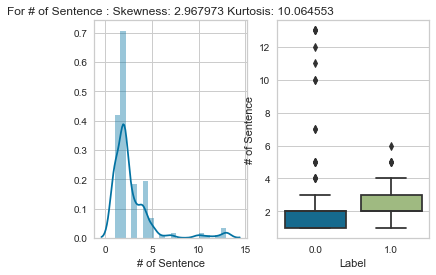

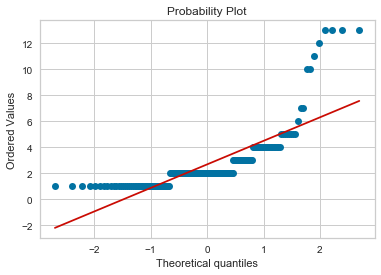

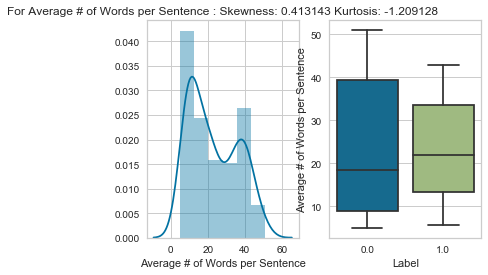

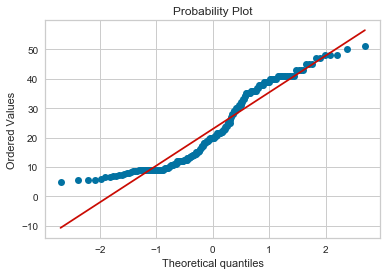

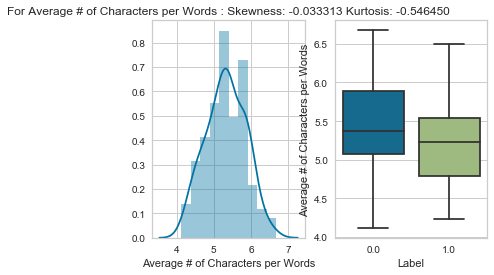

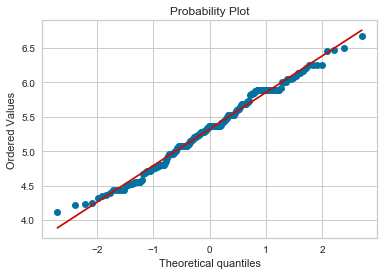

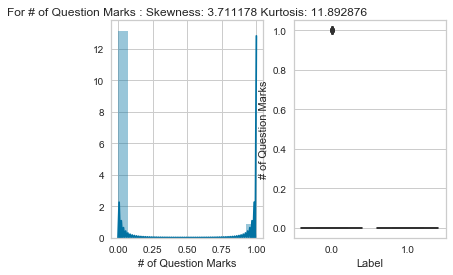

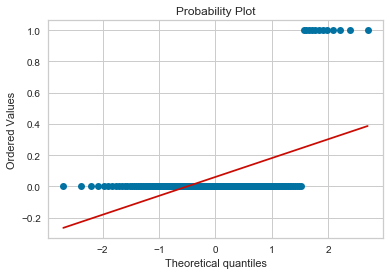

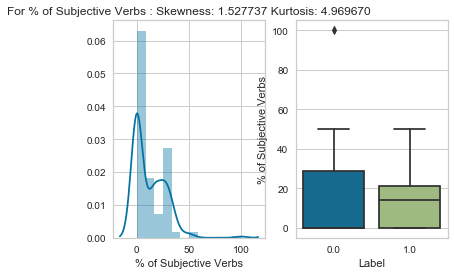

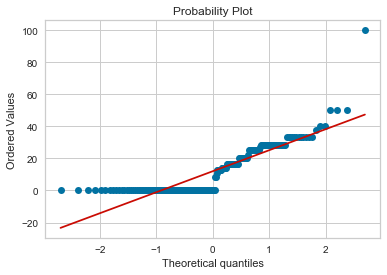

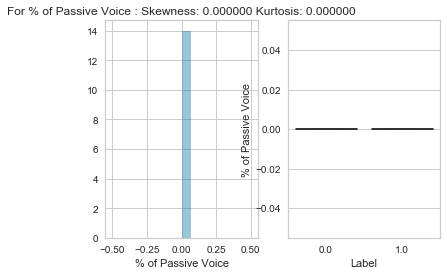

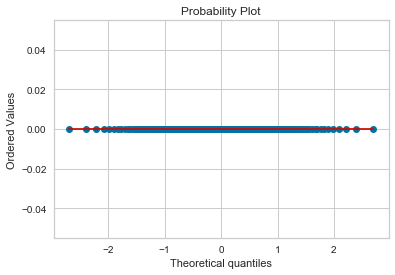

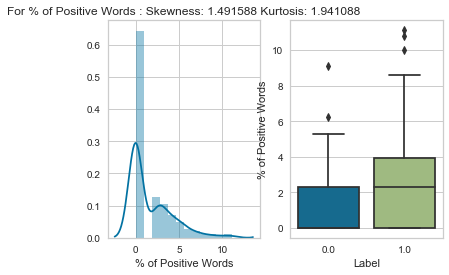

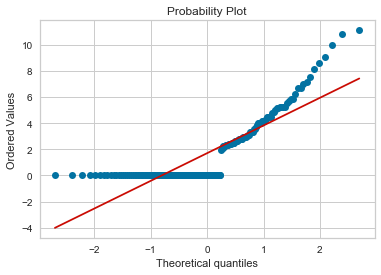

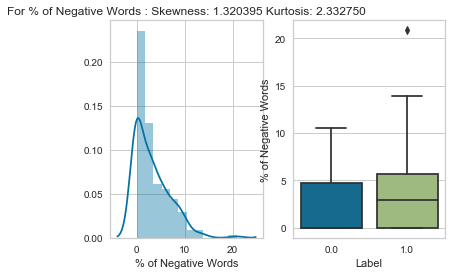

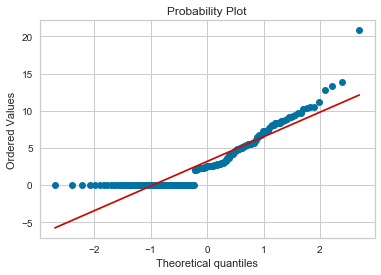

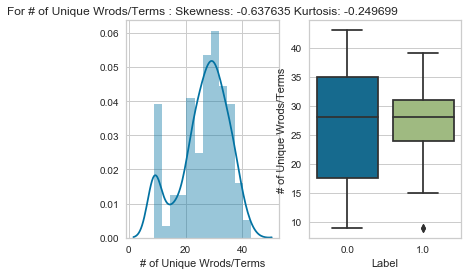

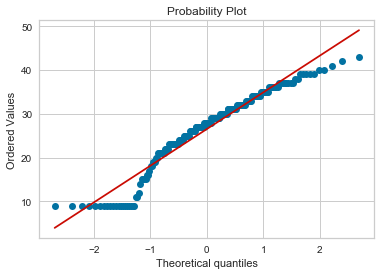

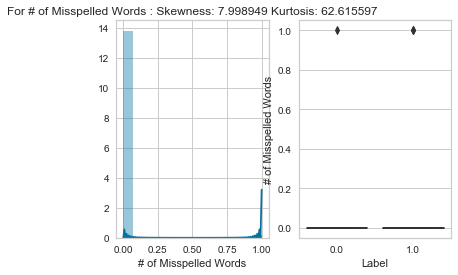

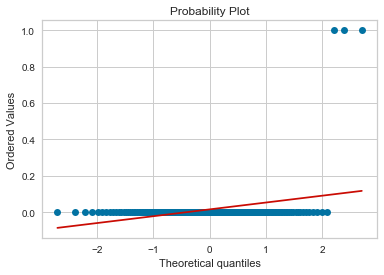

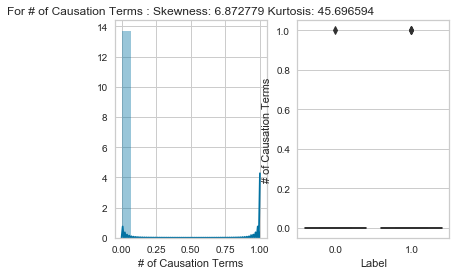

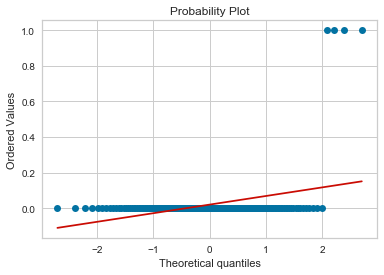

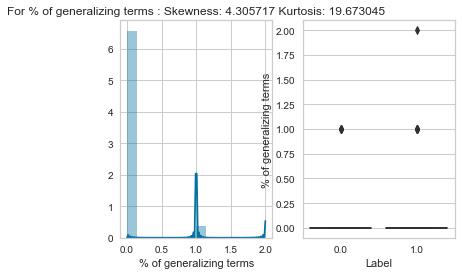

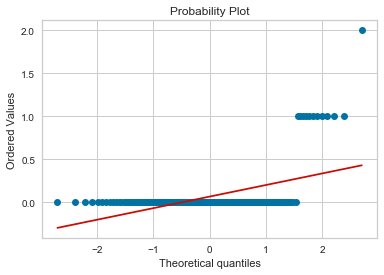

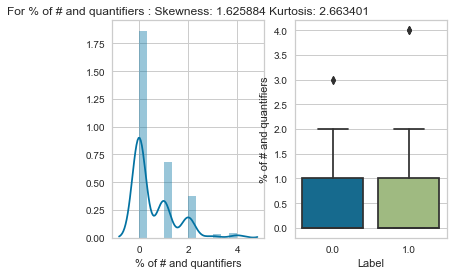

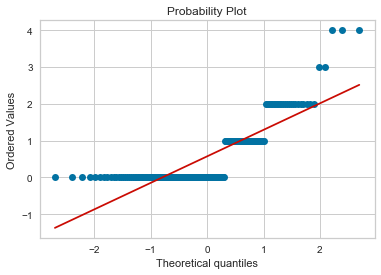

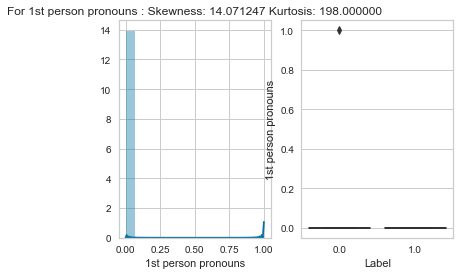

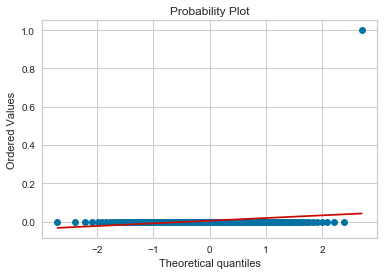

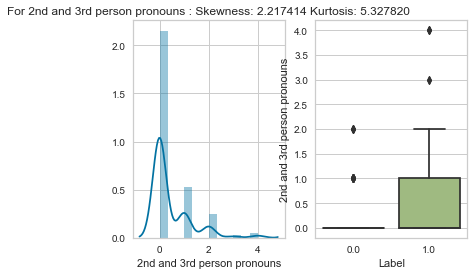

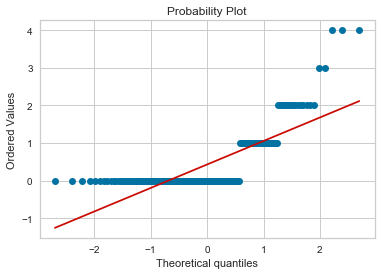

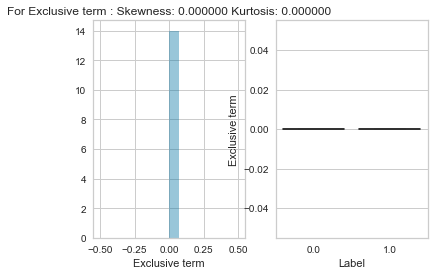

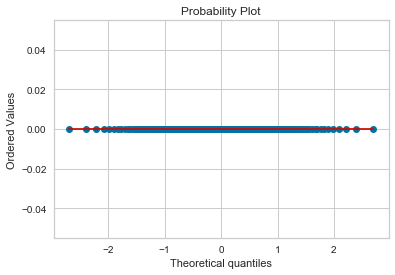

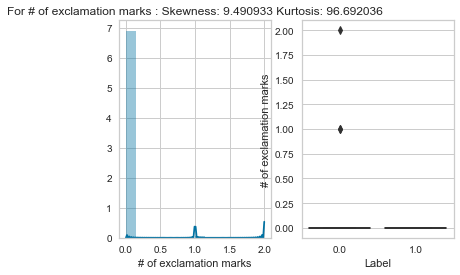

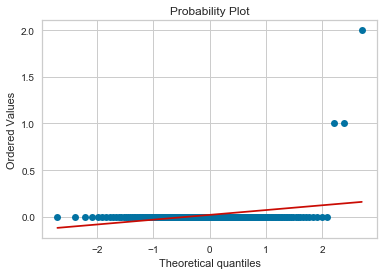

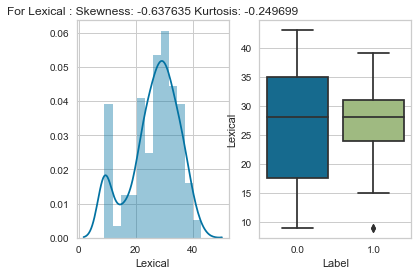

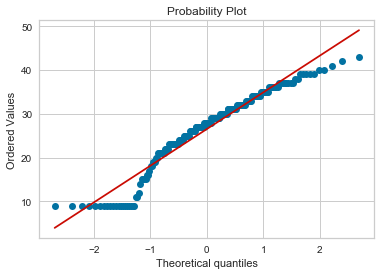

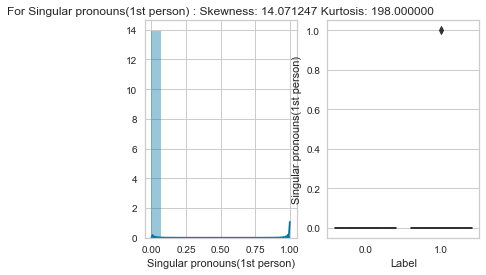

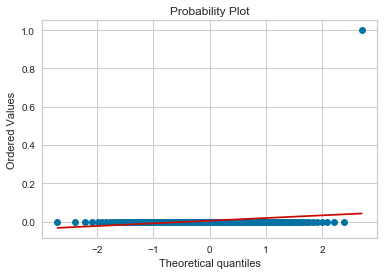

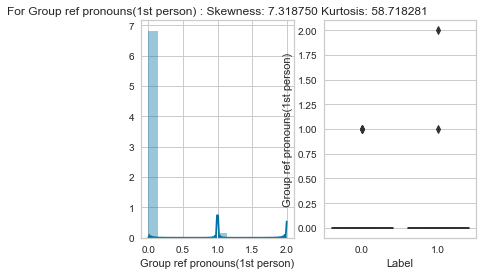

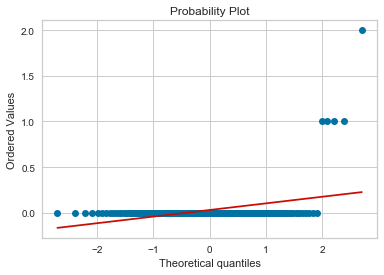

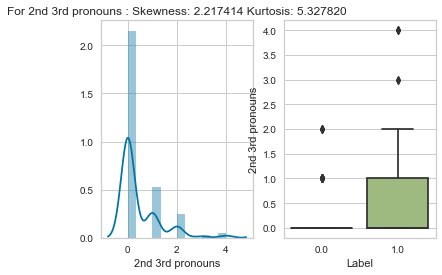

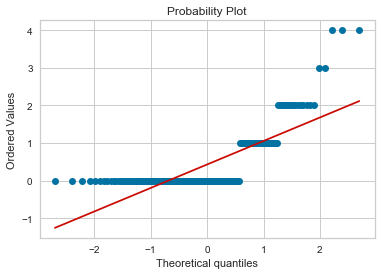

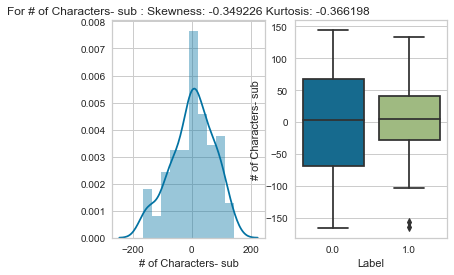

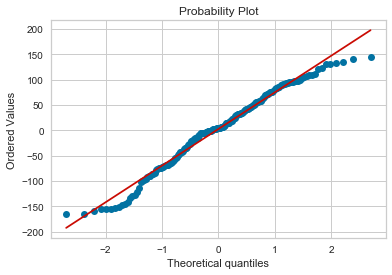

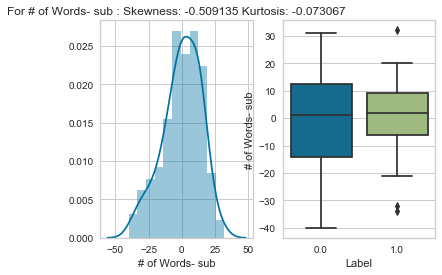

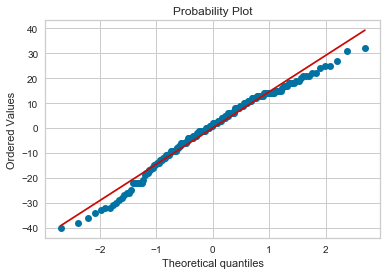

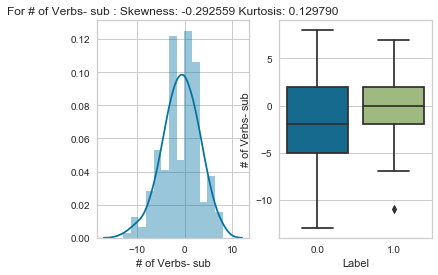

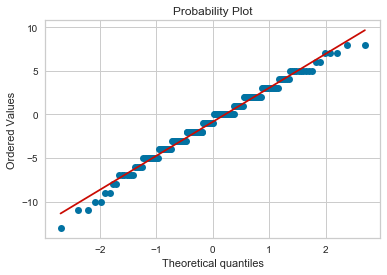

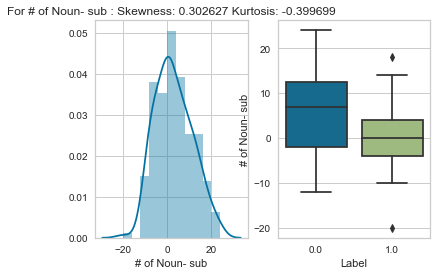

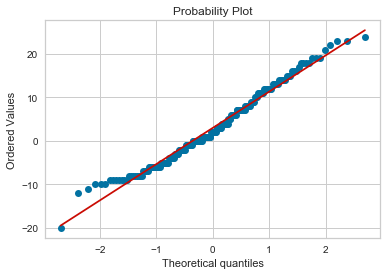

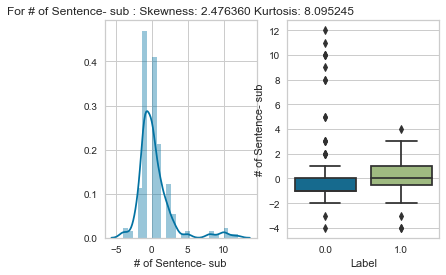

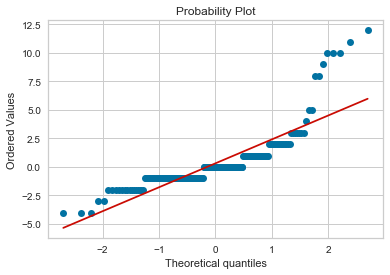

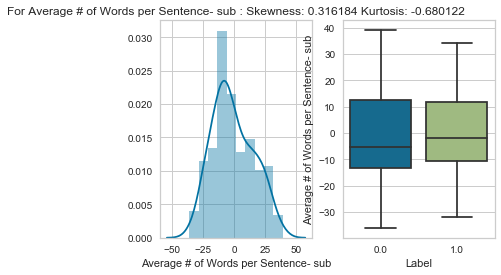

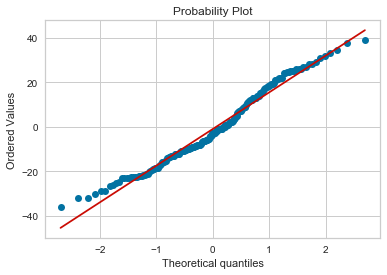

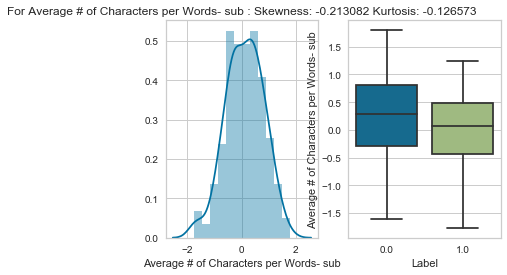

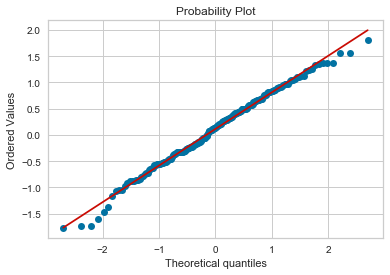

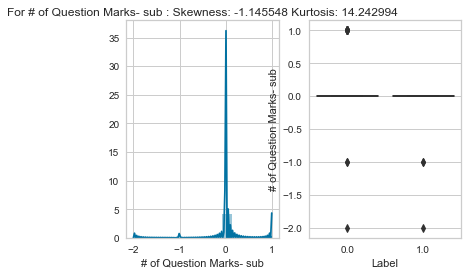

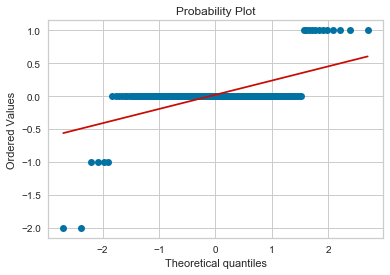

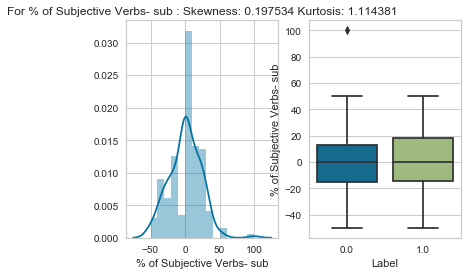

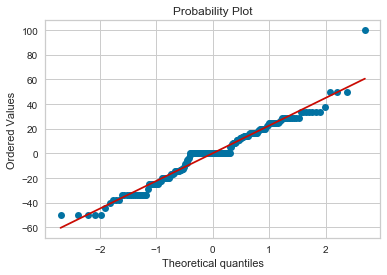

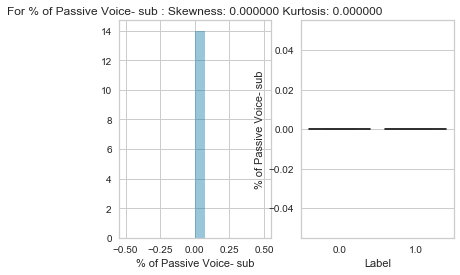

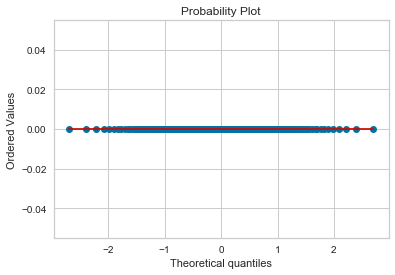

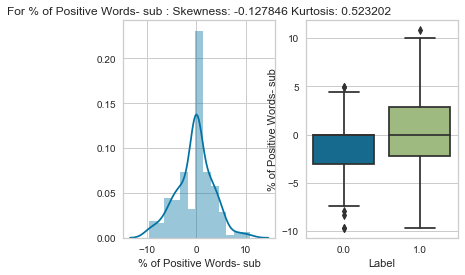

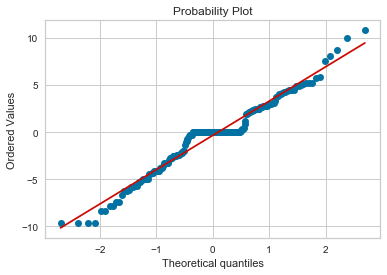

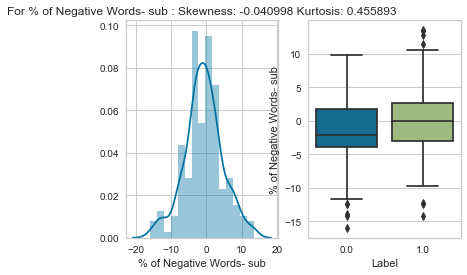

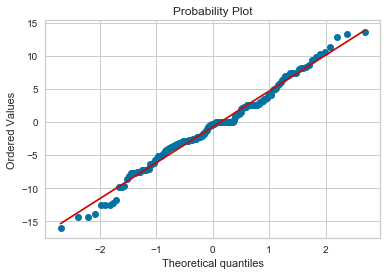

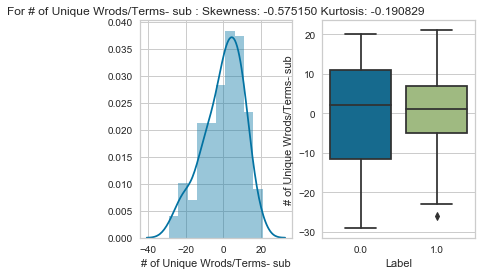

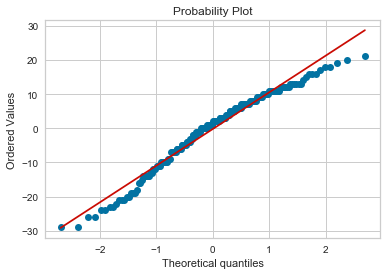

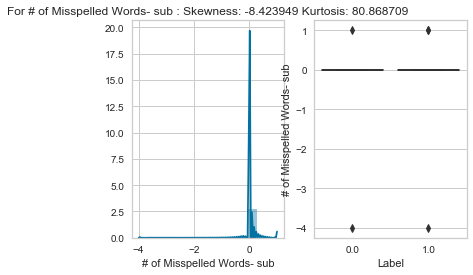

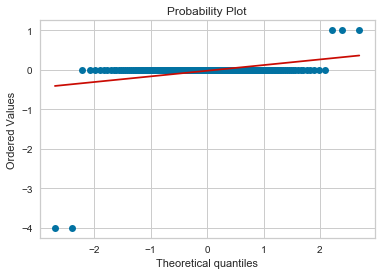

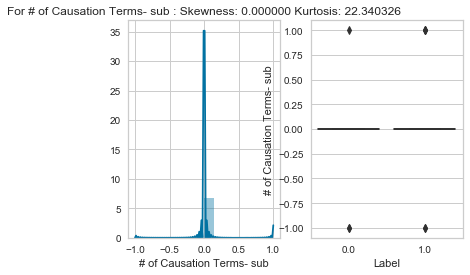

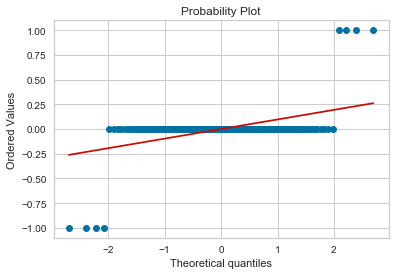

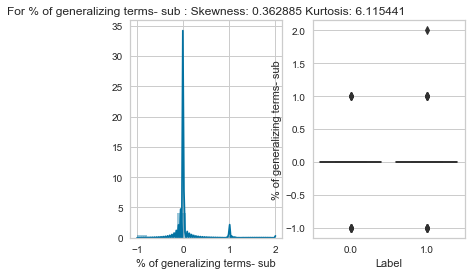

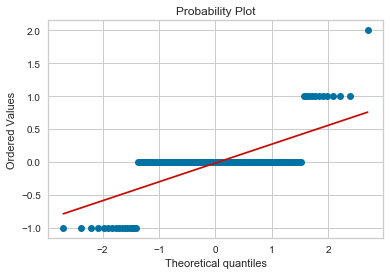

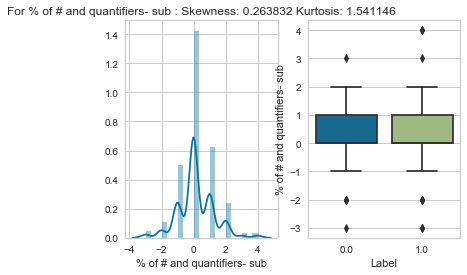

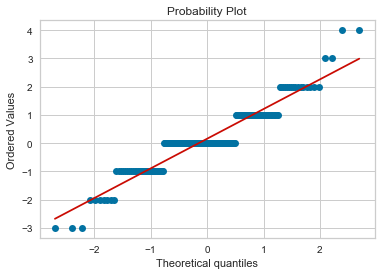

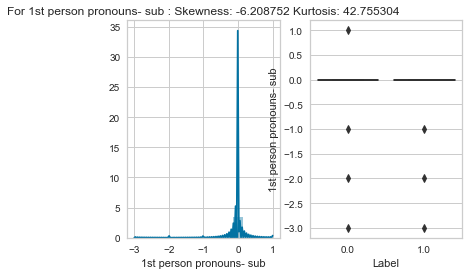

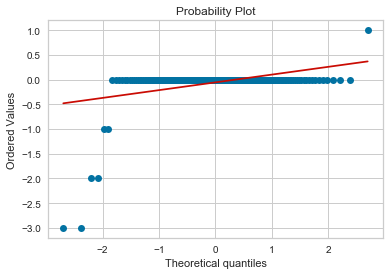

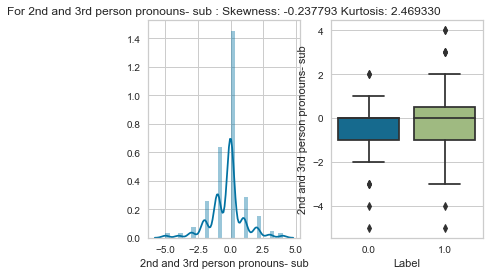

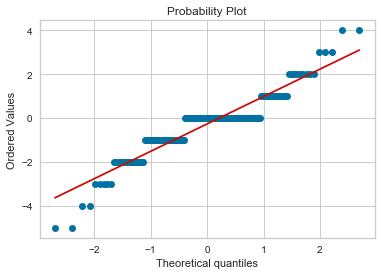

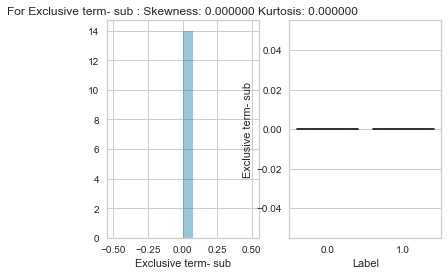

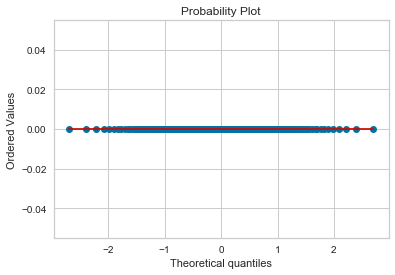

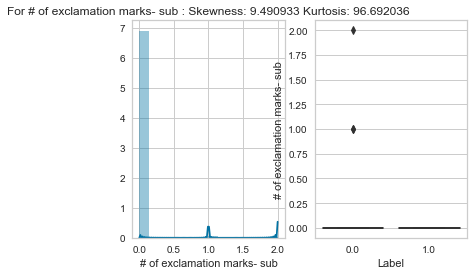

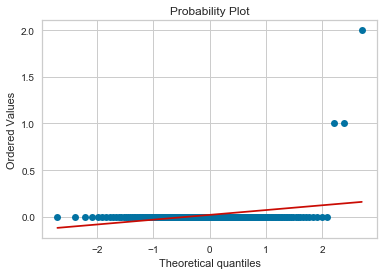

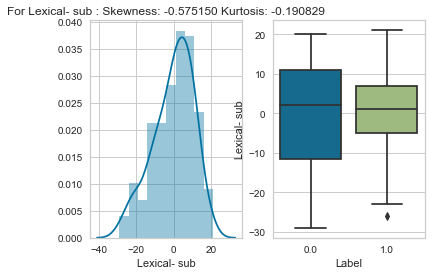

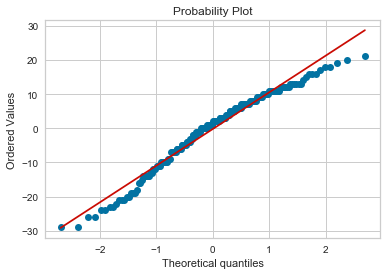

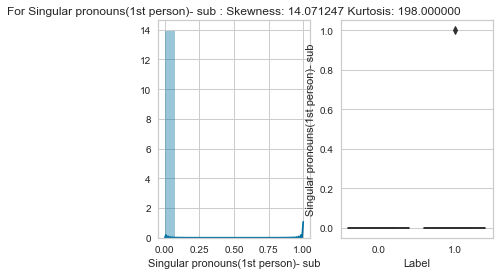

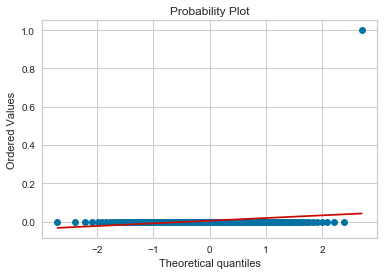

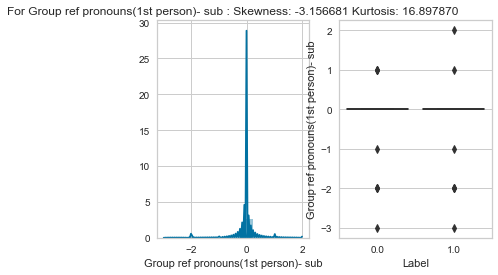

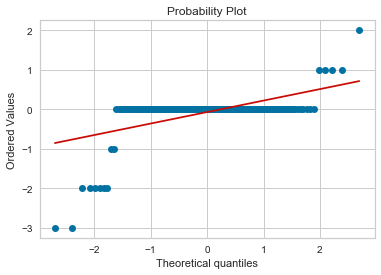

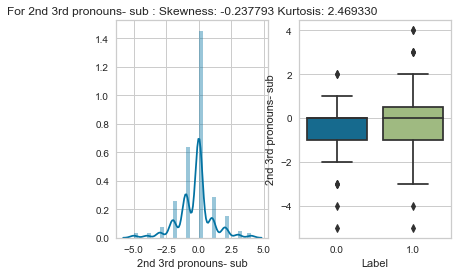

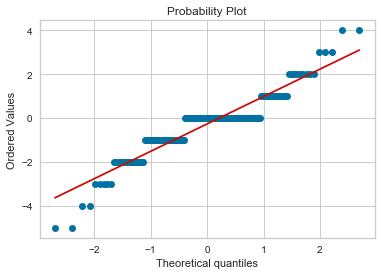

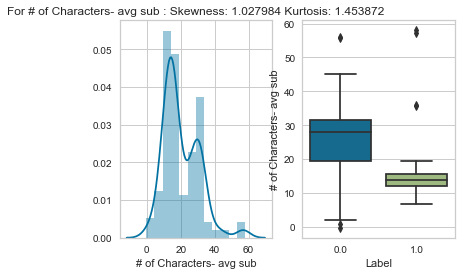

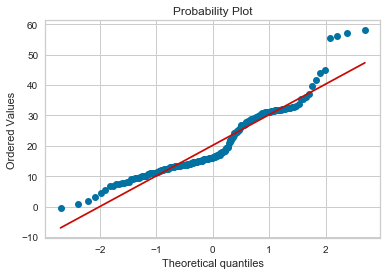

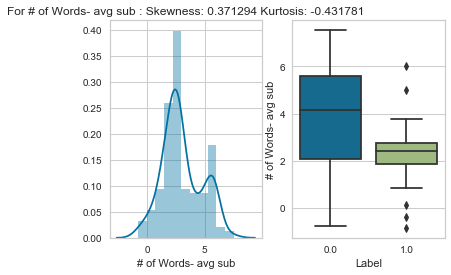

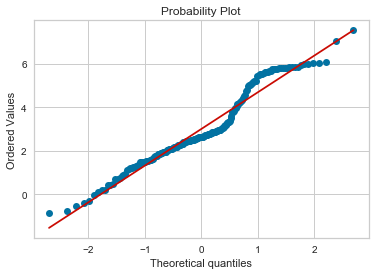

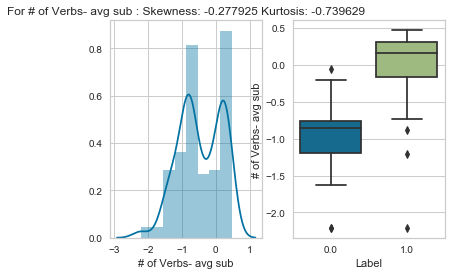

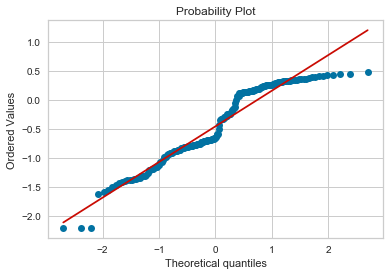

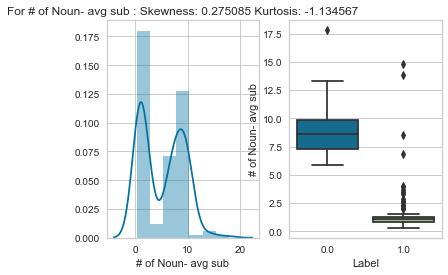

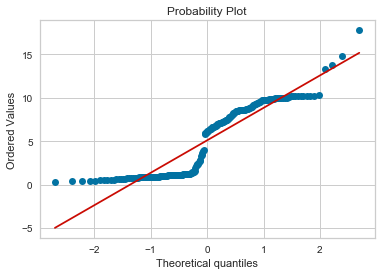

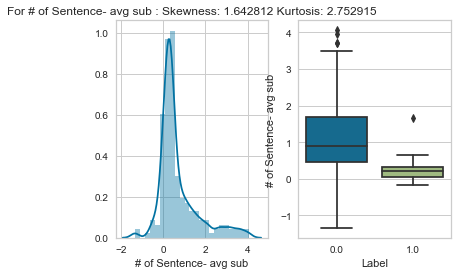

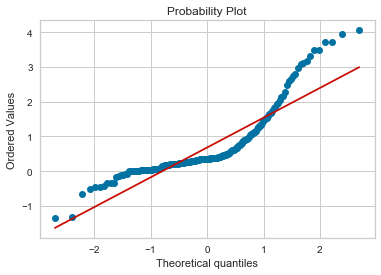

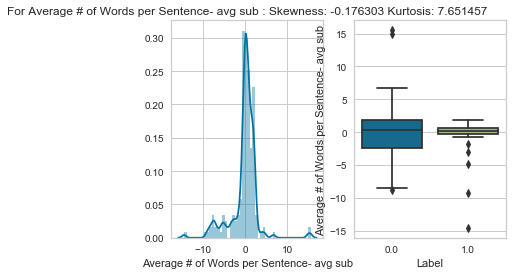

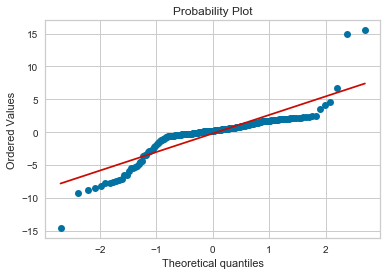

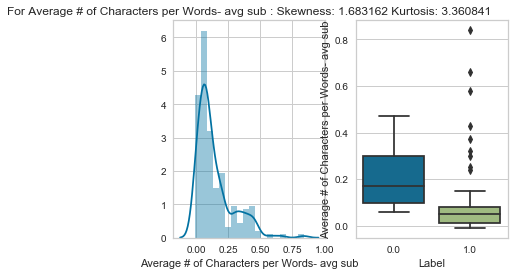

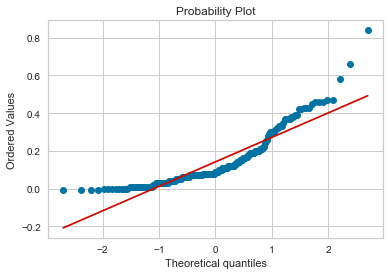

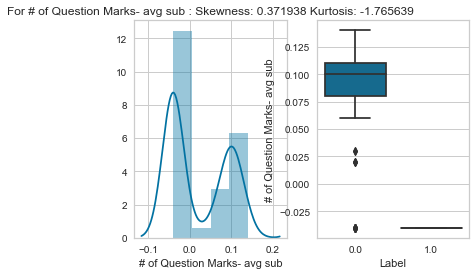

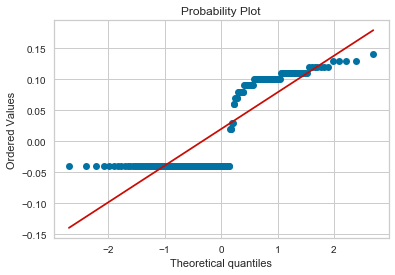

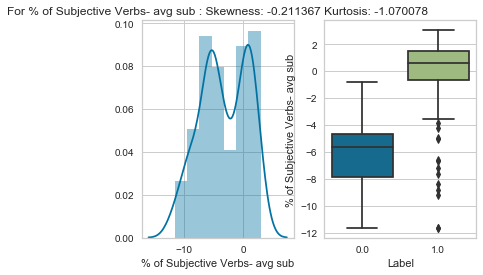

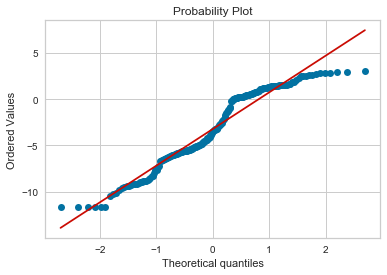

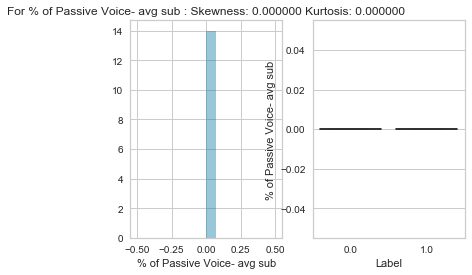

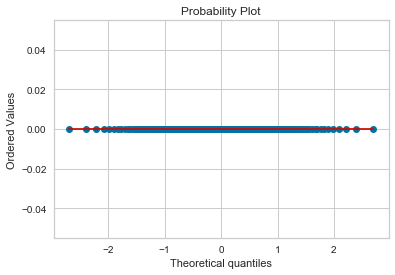

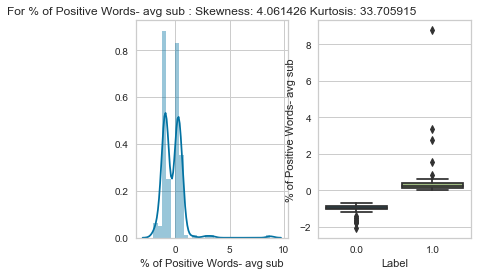

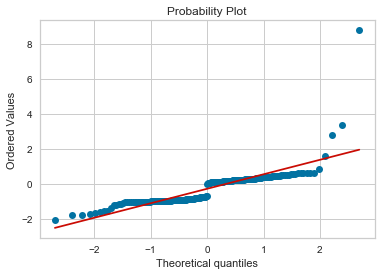

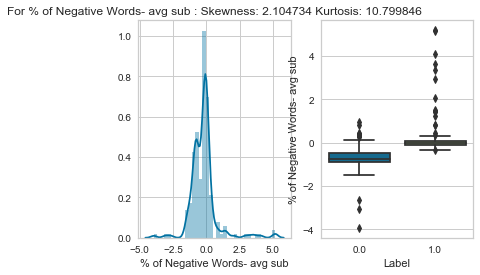

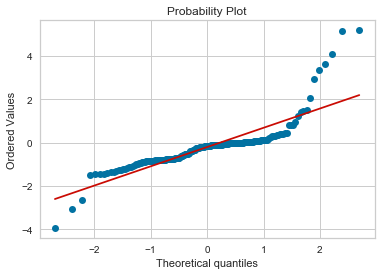

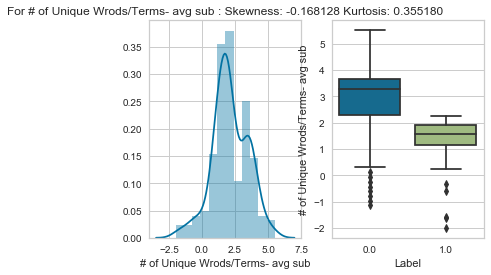

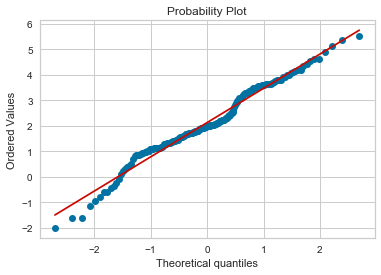

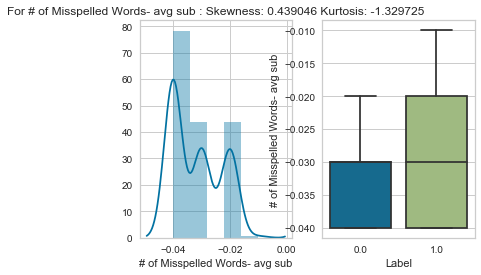

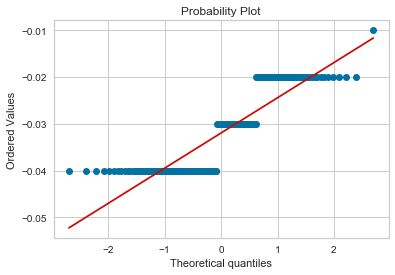

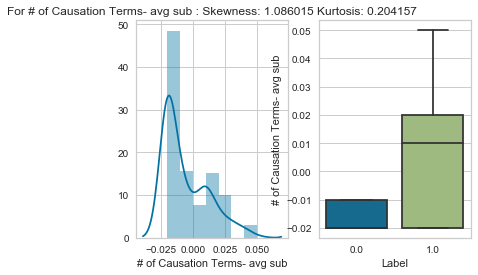

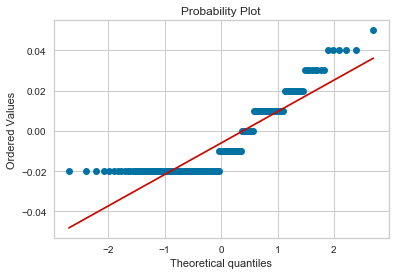

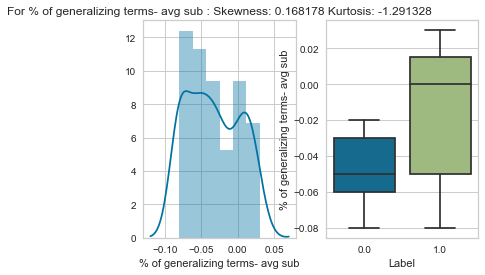

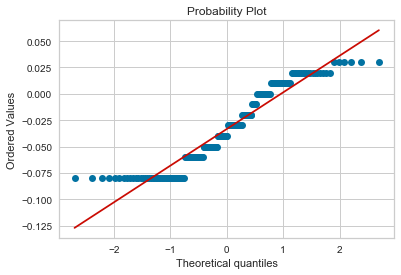

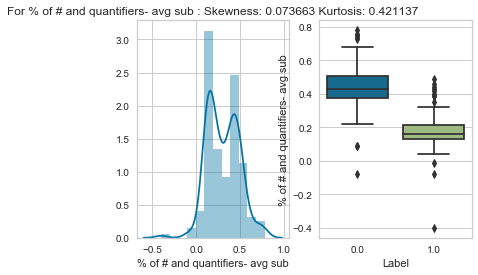

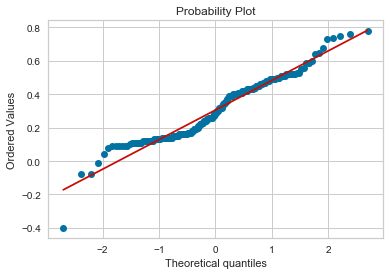

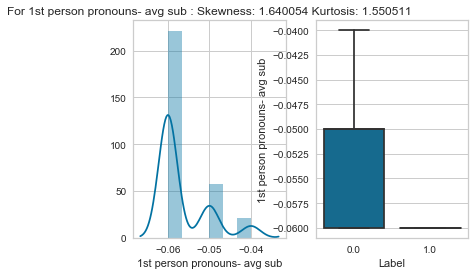

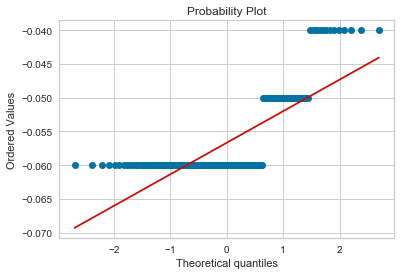

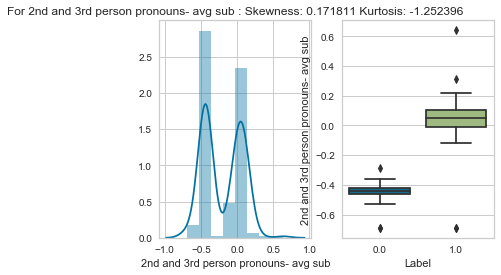

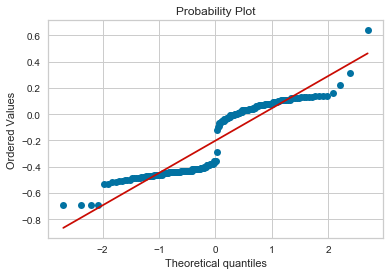

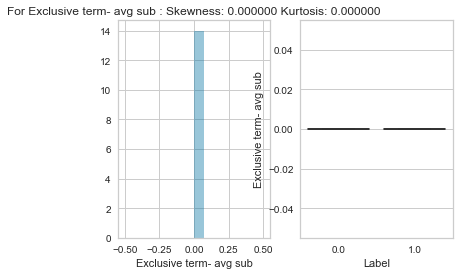

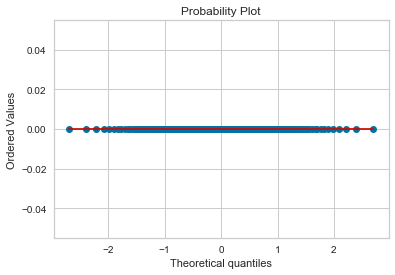

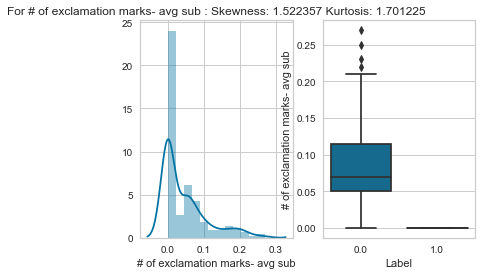

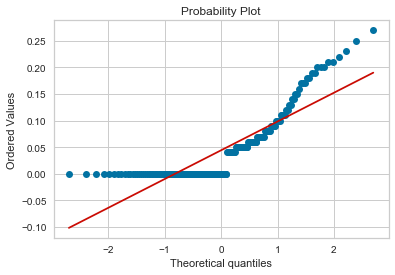

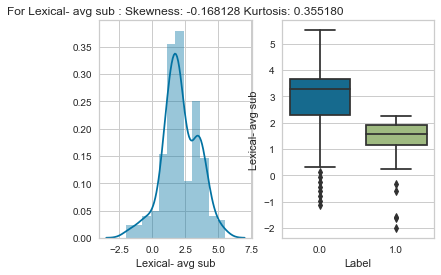

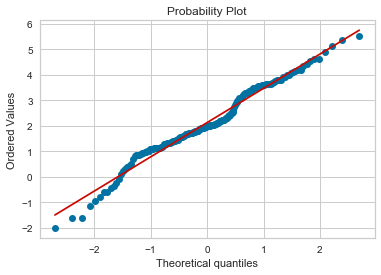

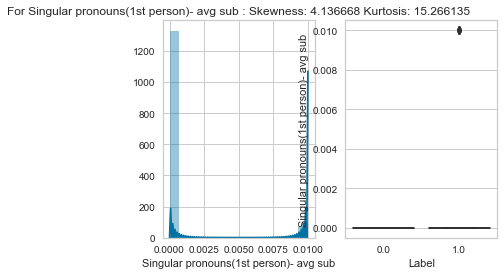

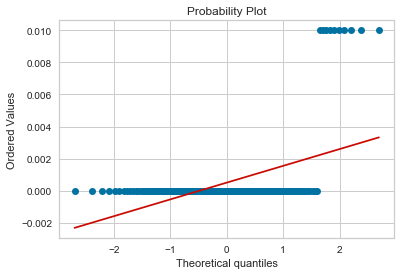

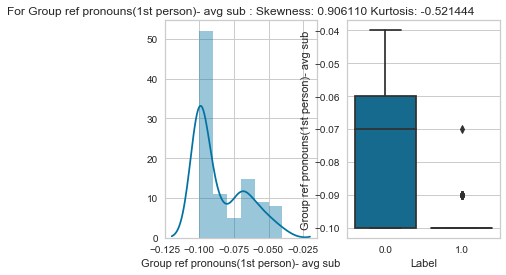

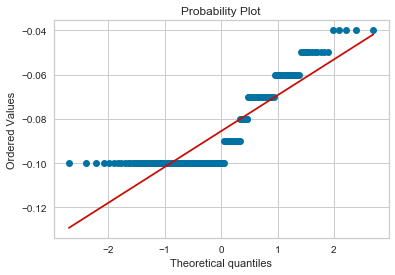

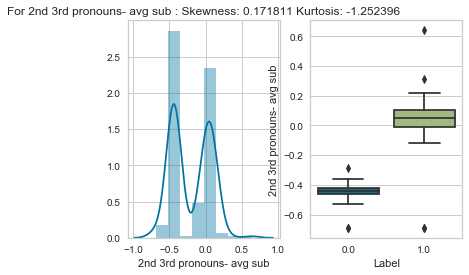

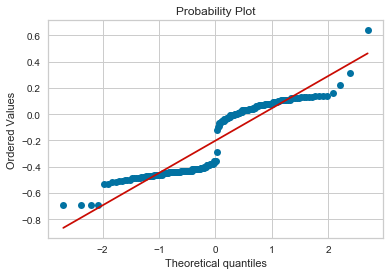

In [35]:
for var in feature_list:
    feature_distrib(var)

<h2> Bivariate analysis <!h2>

In [36]:
#bivariate analysis reliablity/x
def feature_scatter(feature):
    Fdata = pd.concat([data['Label'], data[var]], axis=1)
    Fdata.plot.scatter(x='Label', y=var);

In [37]:
#for var in feature_list:
#    feature_scatter(var)

<h2>deeper analysis on selected features<!h2>

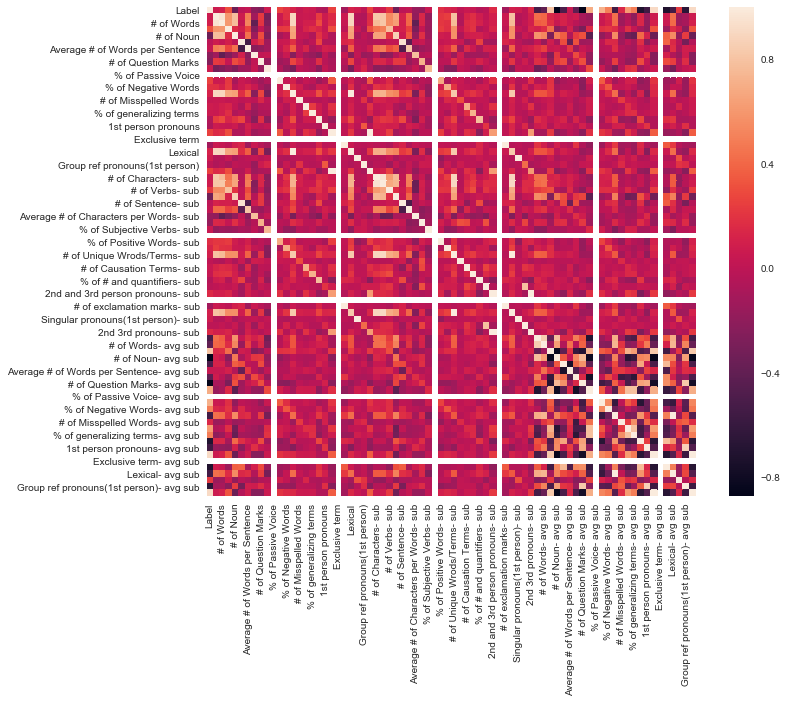

In [38]:
#correlation matrix to detect multicollinearity (one feature predict another linearly)
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);


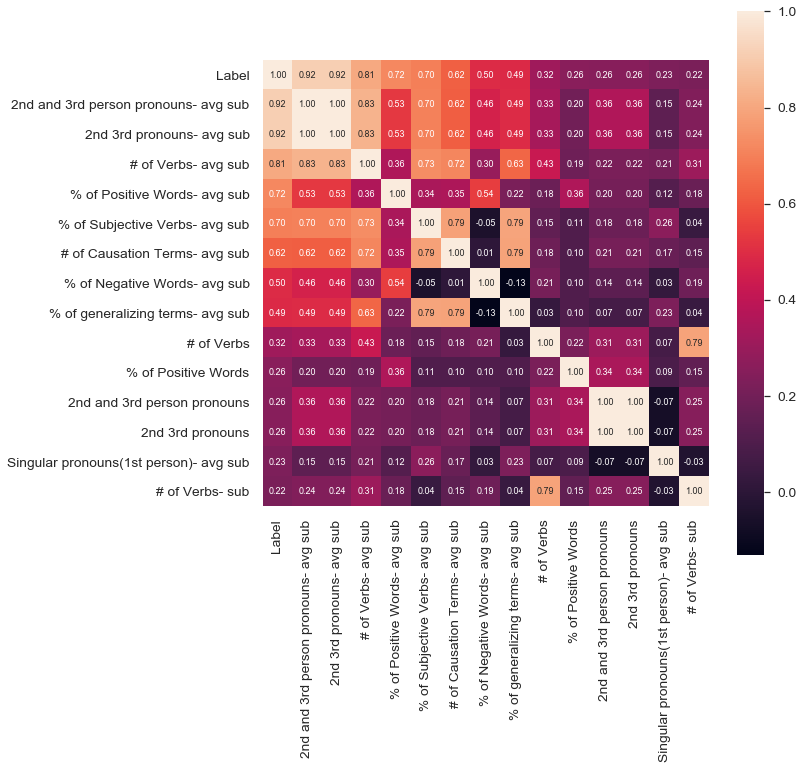

In [39]:
#correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Label')['Label'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values, ax = ax)
plt.show()

In [40]:
#scatterplot
#sns.set()
#sns.pairplot(data[cols], size = 5)
#plt.show();

In [41]:
# Save chosen features data as dataframe and csv file

chosen_features = pd.concat([data['Text'], data['Reference'], data[cols]], axis = 1)
print(chosen_features.head(5))

chosen_features.to_csv("ChosenFeatures.csv")

                                                Text  \
0  WATCH LIVE: Federal Reserve Chairman Powell te...   
1  China Vows More Fiscal Support as Virus Roils ...   
2  Feb.05 -- President Donald Trump talks about t...   
3  Beijing imposes strict quarantine rules | WION...   
4  Coronavirus outbreak: Virus now deadlier than ...   

                                           Reference  Label  \
0  Federal Reserve chairman Jerome Powell on Tues...    0.0   
1  CNN's Alisyn Camerota speaks with South Caroli...    0.0   
2  The State of the Union address Tuesday night g...    0.0   
3  The US economy expanded at an annualized rate ...    0.0   
4  Fareed gives his take on the folly of Trump's ...    0.0   

   2nd and 3rd person pronouns- avg sub  2nd 3rd pronouns- avg sub  \
0                                 -0.69                      -0.69   
1                                 -0.69                      -0.69   
2                                 -0.36                      -0.36   
3   

# Test with Machine Learning

Using chosen features, the news data were tested with machine learning algorithms.

# Create Empty Model

In [46]:
# Create pipeline for Gaussian NB
pipeline = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors = None))
#pred_nb = pipeline.fit(x_train, y_train).predict(x_test)

neigh = KNeighborsClassifier(n_neighbors = 3)
#pred_KN = neigh.fit(x_train, y_train).predict(x_test)

# Fit and cross validate with KFold method

In [78]:
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
chosen_features = shuffle(chosen_features, random_state = 100)

y = chosen_features['Label'][:160]
x = chosen_features[cols.drop('Label')][:160]
x_test = chosen_features[cols.drop('Label')][161:]
y_test = chosen_features['Label'][161:]
kf = KFold(n_splits = 10, shuffle = False)
kf.get_n_splits(x)

acc_kn = []
acc_nb = []

for train_index, test_index in kf.split(x):
    #print("TRAIN:", x.iloc[train_index], "TEST:", x.iloc[test_index])
    
    clf = neigh.fit(x.iloc[train_index], y.iloc[train_index])
    pred = clf.predict(x.iloc[test_index])
    acc_kn.append(accuracy_score(y.iloc[test_index], pred))
    
    clf2 = pipeline.fit(x.iloc[train_index], y.iloc[train_index])
    pred2 = clf2.predict(x.iloc[test_index])
    acc_nb.append(accuracy_score(y.iloc[test_index], pred2))
    
print(acc_kn)
print(acc_nb)
a = clf.predict(x_test)
print(a)
print('accuracy_KN: ', accuracy_score(y_test, a))
print('f1: ', f1_score(y_test, a))

a1 = clf2.predict(x_test)
#print(y_test)
print(a1)
print('accuracy_GNB: ', accuracy_score(y_test, a1))
print('f1: ', f1_score(y_test, a1))

10

[0.9375, 1.0, 0.875, 0.9375, 1.0, 1.0, 1.0, 1.0, 0.875, 0.875]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
accuracy:  0.9459459459459459
f1:  0.9444444444444444
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
accuracy:  1.0
f1:  1.0


# Have to be fixed after this

Try to use cross_val_score()

In [80]:
# Separate train and test set from the data
y = chosen_features['Label']
x = chosen_features[cols.drop('Label')]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 100, stratify = y)

In [81]:
y = chosen_features['Label'][:160]
x = chosen_features[cols.drop('Label')][:160]

# Evaluating GNB
print("GNB Accuracy: ", accuracy_score(y_test, pred_nb))
print("GNB F1 Score: ", f1_score(y_test, pred_nb))

visualizer1 = ClassificationReport(pipeline, classes=['Fake', 'Not Fake'])
visualizer1.fit(x_train, y_train)
visualizer1.score(x_test, y_test)
visualizer1.show()

# Apply KNeighbors classifier


# Evaluating KNeighbors Classifier
print("KNeighbors Accuracy: ", accuracy_score(y_test, pred_KN))
print("KNeighbors F1 Score: ", f1_score(y_test, pred_KN))

visualizer2 = ClassificationReport(neigh, classes=['Fake', 'Not Fake'])
visualizer2.fit(x_train, y_train)
visualizer2.score(x_test, y_test)
visualizer2.show()

# Draw confusion matrix for GNB and KNeighbors
conf_matrix1 = confusion_matrix(y_test, pred_nb)
print(conf_matrix1)

conf_matrix2 = confusion_matrix(y_test, pred_KN)
print(conf_matrix2)

NameError: name 'pred_nb' is not defined

In [ ]:
# Check for corss validation score

from sklearn.utils import shuffle
chosen_features = shuffle(chosen_features)
y = chosen_features['Label']
x = chosen_features[cols.drop('Label')]

acc_nb = cross_val_score(pipeline.fit(x_train, y_train), x, y, scoring = 'accuracy',cv=10)
print(acc_nb)


from sklearn.model_selection import cross_val_predict
nb = cross_val_predict(pipeline, x, y,cv=10)
print(nb)

acc_kn = cross_val_score(neigh, x, y, scoring = 'accuracy', cv=10)
print(acc_kn)

kn = cross_val_predict(neigh.fit(x_train, y_train), x, y,cv=10)
#print(kn)

f1_nb = cross_val_score(pipeline.fit(x_train, y_train), x, y, scoring = 'f1',cv=10)
print(f1_nb)



f1_kn = cross_val_score(neigh.fit(x_train, y_train), x, y, scoring = 'f1', cv=10)
print(f1_kn)
